# Fig. 6

In [1]:
# %matplotlib notebook
%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import scipy.io as sio
from scipy.interpolate import interp1d


In [2]:
def transport(Data, y0):
    # compute transport at y=y0
    h = Data.H.sel(y=y0, method='nearest')
    v = Data.V.sel(y=y0, method='nearest')
    vh = v*h

    # integrate from y(end): western boundary (uh[:,::-1,:])

    from scipy import integrate
    Q_all = sp.integrate.cumtrapz(vh, Data.x, axis=1) 

    Q_all = xr.DataArray(Q_all[:,-1], dims=['time'], 
                         coords={'time':np.squeeze(Data.time.data)},
                         attrs={'long_name':'Transport at y='+str(y0),
                               'description':'start from x=x(end)'})
    return Q_all

In [3]:
# Compute scales for nondimensional variables
r = 6.371e+6
unit = 2*np.pi*r/360
Omega = 7.292e-5
g = 4e-4
Di = 1000
lat = -8
q = -1
f0 = abs(2*Omega*np.sin(lat/180*np.pi))
Ld = np.sqrt(g*Di)/f0
D = -q*Di

# Best guesses of Samoan Passage
wsn = [0.6, 1.6]
hsn = 0.6

# other examples
wn = [0.6, 1.6, 2.8, 4.0]
hn = [0.2, 0.6, 0.8, 1.0, 1.4]
dn = 0.5
rn = (np.power((np.array(wn)/2.0), 2)/dn).tolist()

Q = 0.5
dQ = np.arange(0, Q - 1e-6, Q/5)

In [4]:
# load Gill's model outputs from a .mat dataset
data_path = '../data/'
data_name = 'Gill_parabola.mat'
data = sio.loadmat(data_path + data_name, squeeze_me=True,
                   struct_as_record=False)
type(data)
dict.keys(data)

dict_keys(['__header__', '__version__', '__globals__', 'Di', 'Q', 'Q1', 'Q1_1', 'Q1_2', 'Q1_int', 'amnsb', 'aplsb', 'bc', 'dc', 'dl', 'dr', 'g', 'rc', 'vl', 'vr', 'w1c'])

In [5]:
# Only pick out Q1 with q=-1 and Q=0.5
# del Q1, w1c, Q
Q1 = data['Q1_int']
rc = data['rc']
bc = data['bc']
vl = data['vl']
vr = data['vr']
dl = data['dl']
dr = data['dr']
Q1.shape
del data
type(Q1)

# compute non-dimensionalized data
# Q1 = Q1*f0/g/D/D
Q1.shape
Q1 = Q1.transpose()
vl = vl.transpose()
vr = vr.transpose()
dl = dl.transpose()
dr = dr.transpose()

In [6]:
# Fill non-zero boundary layerthickness with nan
Q1[abs(dl.real) > 0.01] = np.nan
Q1[abs(dr.real) > 0.01] = np.nan

# Fill negative right boundary velocity with nan
Q1[vr.real < 0] = np.nan

In [7]:
# load nondimensional Q1 from the best guesses

data = sio.loadmat(data_path + 'Gill_parabola_SP.mat',
                   squeeze_me=True, struct_as_record=False)
Q1s = data['Q1']
H1s = data['H']
D1s = data['D']
U1s = data['V']
X1s = data['X0']

In [8]:
# load Q1 from Samoan model outputs

wms = np.array([1.6, 0.6])
rms = (np.power((np.array(wms)/2.0), 2)/dn)
hms = np.array([0.6, 0.6])

circuit to track Kelvin waves: contours following d+h=0.6 and 0.8

In [9]:
def extract_data(Data):
    """ Extract and regulate data from xarray Dataset. (x, y) - (east, north)"""
    # ragulate data
    t = Data.time.data
    d = Data.H.data
    v = Data.U.data # northward
    u = Data.V.data # westward
    h = Data.B.data
    # dims=['time', 'y', 'x']
    # (y, x) is in fact (west, north) convert to (x, y) or (east, north)
    u = -u[:,::-1,:] # now the flow speed is toward east
    v = v[:,::-1,:]
    d = d[:,::-1,:]
    h = h[::-1,:]
    x = Data.y.data 
    y = Data.x.data
    return x,y,t,d,h,v,u

def find_nearest(array, value):
    """ Find the nearest point of
        code stolen from https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx


In [10]:
def build_data(x,y,t,d,h,v,u):
    """ Build xarray Dataset. (x, y) - (east, north)"""
    # build DataArray
    spd = np.sqrt(u**2 + v**2)
    B = xr.DataArray(h, dims=['x', 'y'], 
                    coords={'x': x, 
                            'y': y},
                    attrs={'long_name':'Bottom Elevation'})
    H = xr.DataArray(d, dims=['time', 'x', 'y'], 
                    coords={'time':t, 
                            'x': x, 
                            'y': y},
                    attrs={'long_name':'Layer Thickness'})
    U = xr.DataArray(u, dims=['time', 'x', 'y'], 
                    coords={'time':t, 
                            'x': x, 
                            'y': y},
                    attrs={'long_name':'Eastward Velocity'})
    V = xr.DataArray(v, dims=['time', 'x', 'y'], 
                    coords={'time':t, 
                            'x': x, 
                            'y': y},
                    attrs={'long_name':'Northward Velocity'})    
    SPD = xr.DataArray(spd, dims=['time', 'x', 'y'], 
                    coords={'time':t, 
                            'x': x, 
                            'y': y},
                    attrs={'long_name':'Speed'})    
    
    # build Dataset
    data = xr.Dataset({'B': (['x', 'y'], B),
                       'H': (['time', 'x', 'y'], H),
                       'U': (['time', 'x', 'y'], U),
                       'V': (['time', 'x', 'y'], V),
                       'SPD': (['time', 'x', 'y'], SPD)},
                     coords={'time': t,
                            'x': x, 
                            'y': y},
                     attrs={'title':'Outputs from nondimensional model',
                           'description':'Scales: H~1000 m; L~30 km; T~0.6 d; x -'})
    return data

In [11]:
def find_circuit(x, y, h, yc, h0):
    """ circuit surround the western part of the channel and the island, defined by h=h0 """
    
    dx = np.nanmean(np.diff(x))
    if np.isnan(x[0]):
        x[0] = x[1] - dx
    
    # indexes of the center of channel
    a, idx_yc = find_nearest(y, yc)
    idx_xc = h[0:100,idx_yc].argmin()
    xc = x[idx_xc]
    
    # three circuits x ranges
    X_ch = x[idx_xc:50]
    X_is = x[50::]
    X_we = x[:idx_xc+1]
    Y_is_so = y[:idx_yc+1]
    Y_is_no = y[idx_yc::]

    # circuit: along the western part of channel, h=h0
    y_ = np.copy(y)
    x_ = np.zeros(len(y_),) + np.nan
    for i in range(len(y_)):
        f = interp1d(h[:idx_xc+1,i], X_we, bounds_error=False, fill_value=np.nan)
        x_[i] = f(h0)
    x_we = x_[~np.isnan(x_)]
    y_we = y_[~np.isnan(x_)]
    
        
    # circuit: along the island, h=h0
    # Part1: along the eastern part of channel
    y_ = np.copy(y)
    x_ = np.zeros(len(y_),) + np.nan
    for i in range(len(y_)):
        f = interp1d(h[idx_xc:50,i], X_ch, bounds_error=False, fill_value=np.nan)
        x_[i] = f(h0)
    x_ch = x_[~np.isnan(x_)]
    y_ch = y_[~np.isnan(x_)]   #clockwise 
    # Part3: along the rest of the island
    y_ = np.copy(y)
    x_ = np.zeros(len(y_),) + np.nan
    for i in range(len(y_)):
        f = interp1d(h[50::,i], X_is, bounds_error=False, fill_value=np.nan)
        x_[i] = f(h0)
    x_is = x_[~np.isnan(x_)]   #anticlockwise 
    y_is = y_[~np.isnan(x_)]    
    # Part2: north part of the island
    dx = np.nanmean(np.diff(x))
    x_ = x[find_nearest(x, x_ch[-1])[1]-1:find_nearest(x, x_is[-1])[1]+1]
    y_ = np.zeros(len(x_),) + np.nan
    for i in range(len(y_)):
        ii = find_nearest(x, x_[i])[1]
        f = interp1d(h[ii,idx_yc::], Y_is_no, bounds_error=False, fill_value=np.nan)
        y_[i] = f(h0)
    x_is_no = x_[np.where((x_>x_ch[-1]) & (x_<x_is[-1]))]   #clockwise 
    y_is_no = y_[np.where((x_>x_ch[-1]) & (x_<x_is[-1]))]
    # Part4: south part of the island
    dx = np.nanmean(np.diff(x))
    x_ = x[find_nearest(x, x_ch[0])[1]-1:find_nearest(x, x_is[0])[1]+1]
    y_ = np.zeros(len(x_),) + np.nan
    for i in range(len(y_)):
        ii = find_nearest(x, x_[i])[1]
        f = interp1d(h[ii,:idx_yc+1], Y_is_so, bounds_error=False, fill_value=np.nan)
        y_[i] = f(h0)
    x_is_so = x_[np.where((x_>x_ch[0]) & (x_<x_is[0]))]   #anticlockwise 
    y_is_so = y_[np.where((x_>x_ch[0]) & (x_<x_is[0]))]
    
    
#     x_ea = np.concatenate((x_ch, x_is_no, x_is[::-1], x_is_so[::-1]))
#     y_ea = np.concatenate((y_ch, y_is_no, y_is[::-1], y_is_so[::-1]))
    x_ea = np.concatenate((x_is_so, x_is, x_is_no[::-1], x_ch[::-1]))
    y_ea = np.concatenate((y_is_so, y_is, y_is_no[::-1], y_ch[::-1]))

    return x_we, y_we, x_ea, y_ea

Plot

Contact S.Tan for friction (exp1, exp2) and no-friction (exp11, exp12) model outputs

In [12]:
model_path = '/Users/tantanmeow/Desktop/WORK/MODEL/Onelayer/try5/Par_1_finalexperiments/'

In [13]:
from matplotlib import gridspec
from matplotlib import cm
cmap=cm.RdBu_r
cmap.set_bad('gray',1.)
cmap1=cm.Reds
cmap1.set_bad('gray',1.)

# ---------- Friction model ---------- 
i = 1
Data1 = xr.open_dataset(model_path + 'Data_' + np.str(i) + '.nc')
Topo1 = xr.open_dataset(model_path + 'Topo_' + np.str(i) + '.nc')
Out1 = xr.open_dataset(model_path + 'Out_' + np.str(i) + '.nc')
i = 2
Data2 = xr.open_dataset(model_path + 'Data_' + np.str(i) + '.nc')
Topo2 = xr.open_dataset(model_path + 'Topo_' + np.str(i) + '.nc')
Out2 = xr.open_dataset(model_path + 'Out_' + np.str(i) + '.nc')

# make coordinates correct: v/y means north-south, u/x means west-east and rebuild dataset
x, y, t, d, h, v, u = extract_data(Data1)
v[d < 1e-7] = np.nan
d[d < 1e-7] = np.nan
Data1 = build_data(x,y,t,d,h,v,u) 

/Users/tantanmeow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


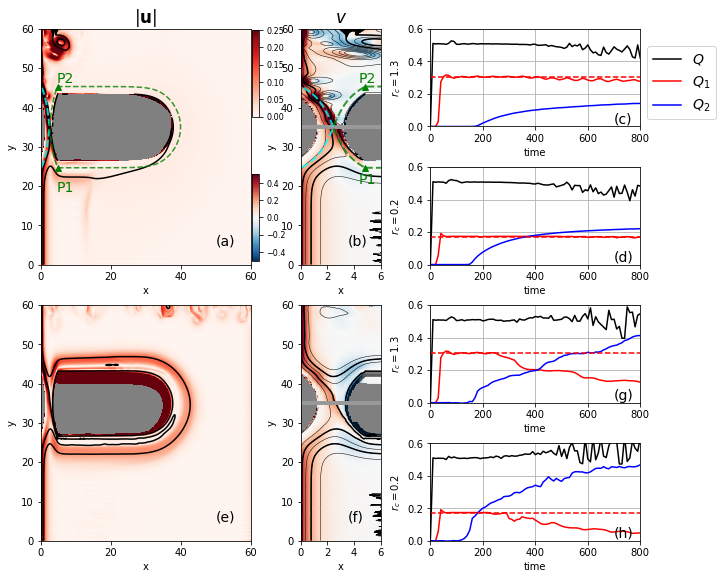

In [14]:
from matplotlib import gridspec
from matplotlib import cm
cmap=cm.RdBu_r
cmap.set_bad('gray',1.)
cmap1=cm.Reds
cmap1.set_bad('gray',1.)

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(4, 5)

ax_a = plt.subplot(gs[0:2, 0:2])
ax_b = plt.subplot(gs[0:2, 2])
ax_c = plt.subplot(gs[0, -2::])
ax_d = plt.subplot(gs[1, -2::])

ax_e = plt.subplot(gs[2::, 0:2])
ax_f = plt.subplot(gs[2::, 2])
ax_g = plt.subplot(gs[-2, -2::])
ax_h = plt.subplot(gs[-1, -2::])

matplotlib.rcParams.update({'font.size': 14})

# ---------- Friction model ---------- 
i = 1
Data1 = xr.open_dataset(model_path + 'Data_' + np.str(i) + '.nc')
Topo1 = xr.open_dataset(model_path + 'Topo_' + np.str(i) + '.nc')
Out1 = xr.open_dataset(model_path + 'Out_' + np.str(i) + '.nc')
i = 2
Data2 = xr.open_dataset(model_path + 'Data_' + np.str(i) + '.nc')
Topo2 = xr.open_dataset(model_path + 'Topo_' + np.str(i) + '.nc')
Out2 = xr.open_dataset(model_path + 'Out_' + np.str(i) + '.nc')

# make coordinates correct: v/y means north-south, u/x means west-east and rebuild dataset
x, y, t, d, h, v, u = extract_data(Data1)
v[d < 1e-7] = np.nan
d[d < 1e-7] = np.nan
Data1 = build_data(x,y,t,d,h,v,u) 
# x, y, t, d, h, v, u = extract_data(Data2)
# v[d < 1e-7] = np.nan
# d[d < 1e-7] = np.nan
# Data2 = build_data(x,y,t,d,h,v,u) 

# circuit
x_we, y_we, x_ea, y_ea = find_circuit(x, y, h, Topo1.xc.data, .6)

cbaxes = fig.add_axes([0.348, 0.8, 0.01, 0.15])
im = Data1.SPD.sel(time=800, method='nearest').T.plot(cmap=cmap1, vmin=0, vmax=0.25, add_colorbar=False, ax=ax_a)# cbar_ax=cbaxes , cbar_kwargs={"label": "", "ticklocation": "left", "pad":.15, "shrink":.1}
cb = ax_a.figure.colorbar(im, orientation="vertical", cax=cbaxes, ticklocation="right")
cb.set_label(label=' ',)#label='Temperature ($^{\circ}$C)', size='large', weight='bold'
cb.ax.tick_params(labelsize=8)# cb.ax.tick_params(labelsize='small')
# ax_a.text(62,58,'$\sqrt{u^2+v^2}$')
# cbaxes.set_title('')
# cbaxes.set_yticks(fontsize=8)
# cbar.tick_params(labelsize=10) 
(Data1.H.sel(time=800, method='nearest')+Data1.B).T.plot.contour(levels=[1.2, 1.4], colors='k', add_colorbar=False, ax=ax_a)
ax_a.plot(x_we, y_we, c='cyan', alpha=0.8, linestyle='--', lw=2)
ax_a.plot(x_ea, y_ea, c='green', alpha=0.8, linestyle='--')
ax_a.set_title('$|\mathbf{u}|$')
ax_a.text(50, 5, '(a)', fontsize=14, color='black')
# ax_a.set_xlabel('')
# ax_a.set_xticklabels('')

im = Data1.V.sel(time=800, method='nearest').T.plot(cmap=cmap, vmin=-.5, vmax=0.5, add_colorbar=False, ax=ax_b)
(Data1.H.sel(time=800, method='nearest')+Data1.B).T.plot.contour(levels=np.arange(0, 2+1e-4, 0.1, dtype=float), colors='k', linewidths=.5, add_colorbar=False, ax=ax_b)
(Data1.H.sel(time=800, method='nearest')+Data1.B).T.plot.contour(levels=[1.2, 1.4], colors='k', add_colorbar=False, ax=ax_b)
ax_b.plot([0, 10], [35, 35], color='0.6', lw=4)
ax_b.plot(x_we, y_we, c='cyan', alpha=0.8, linestyle='--', lw=2)
ax_b.plot(x_ea, y_ea, c='green', alpha=0.8, linestyle='--', lw=2)
ax_b.text(x_ea[0]-.5, y_ea[0]-4, 'P1', fontsize=14, c='green')
ax_b.plot(x_ea[0], y_ea[0], '^', c='green')
ax_b.text(x_ea[y_ea.argmax()]-.5, y_ea[y_ea.argmax()]+1, 'P2', fontsize=14, c='green')
ax_b.plot(x_ea[y_ea.argmax()], y_ea[y_ea.argmax()], '^', c='green')
ax_a.text(x_ea[0]-.5, y_ea[0]-6, 'P1', fontsize=14, c='green')
ax_a.plot(x_ea[0], y_ea[0], '^', c='green')
ax_a.text(x_ea[y_ea.argmax()]-.5, y_ea[y_ea.argmax()]+1, 'P2', fontsize=14, c='green')
ax_a.plot(x_ea[y_ea.argmax()], y_ea[y_ea.argmax()], '^', c='green')
# ax_b.plot(x_ea[0], y_ea[0], c='green', alpha=0.8, marker='p', markersize=10)
# ax_b.plot(x_ea[y_ea.argmax()], y_ea[y_ea.argmax()], c='green', alpha=0.8, marker='^', markersize=10)
ax_b.set_title('$v$')
ax_b.set_xlim([0, 6])
ax_b.set_ylim([0, 60])
ax_b.set_xticks(np.around(np.arange(0, 6+1e-4, step=2),0))
# ax_b.set_ylabel('')
# ax_b.set_xlabel('')
# ax_b.set_xticklabels('')
# ax_b.set_yticklabels('')
ax_b.text(3.5, 5, '(b)', fontsize=14, color='black')
cbaxes = fig.add_axes([0.348, 0.55, 0.01, 0.15])
cb = ax_b.figure.colorbar(im, orientation="vertical", cax=cbaxes, ticklocation="right")
cb.set_label(label=' ')#label='Temperature ($^{\circ}$C)', size='large', weight='bold'
cb.ax.tick_params(labelsize=8)# cb.ax.tick_params(labelsize='small')

Out1.Q_u.plot(c='k', label='$Q$', ax=ax_c)
Out1.Q_c.plot(c='r', label='$Q_1$', ax=ax_c)
Out1.Q_p.plot(c='b', label='$Q_2$', ax=ax_c)
ax_c.plot([0, 800], [Q1s[1,1], Q1s[1,1]], c='r', linestyle='dashed')
ax_c.set_xlim(0, 800)
ax_c.set_ylim(0, 0.6)
ax_c.set_yticks(np.around(np.arange(0, .6+1e-4, step=0.2),2))
ax_c.set_ylabel('$r_c=1.3$')
ax_c.grid(True)
ax_c.legend(bbox_to_anchor=(1,0), loc='lower left', fontsize=14) 
# ax_c.set_xlabel('')
# ax_c.set_xticklabels('')
ax_c.set_title('')
ax_c.text(700, 0.02, '(c)', fontsize=14, color='black')

Out2.Q_u.plot(c='k', label='$Q$', ax=ax_d)
Out2.Q_c.plot(c='r', label='$Q_1$', ax=ax_d)
Out2.Q_p.plot(c='b', label='$Q_2$', ax=ax_d)
ax_d.plot([0, 800], [Q1s[0,1], Q1s[0,1]], c='r', linestyle='dashed')
ax_d.set_xlim(0, 800)
ax_d.set_ylim(0, 0.6)
ax_d.set_yticks(np.around(np.arange(0, .6+1e-4, step=0.2),2))
ax_d.set_ylabel('$r_c=0.2$')
ax_d.grid(True)
# ax_d.set_xlabel('')
# ax_d.set_xticklabels('')
ax_d.set_title('')
ax_d.text(700, 0.02, '(d)', fontsize=14, color='black')

# ---------- No-Friction model ---------- 
i = 11
Data1 = xr.open_dataset(model_path + 'Data_' + np.str(i) + '.nc')
Topo1 = xr.open_dataset(model_path + 'Topo_' + np.str(i) + '.nc')
Out1 = xr.open_dataset(model_path + 'Out_' + np.str(i) + '.nc')
i = 12
Data2 = xr.open_dataset(model_path + 'Data_' + np.str(i) + '.nc')
Topo2 = xr.open_dataset(model_path + 'Topo_' + np.str(i) + '.nc')
Out2 = xr.open_dataset(model_path + 'Out_' + np.str(i) + '.nc')

# make coordinates correct: v/y means north-south, u/x means west-east and rebuild dataset
x, y, t, d, h, v, u = extract_data(Data1)
v[d < 1e-7] = np.nan
d[d < 1e-7] = np.nan
Data1 = build_data(x,y,t,d,h,v,u) 

Data1.SPD.sel(time=800, method='nearest').T.plot(cmap=cmap1, vmin=0, vmax=0.25, add_colorbar=False, ax=ax_e)
(Data1.H.sel(time=800, method='nearest')+Data1.B).T.plot.contour(levels=[1.2, 1.4], colors='k', add_colorbar=False, ax=ax_e)
ax_e.set_title('')
ax_e.text(50, 5, '(e)', fontsize=14, color='black')

Data1.V.sel(time=800, method='nearest').T.plot(cmap=cmap, vmin=-0.5, vmax=0.5, add_colorbar=False, ax=ax_f)
(Data1.H.sel(time=800, method='nearest')+Data1.B).T.plot.contour(levels=np.arange(0, 2+1e-4, 0.1, dtype=float), colors='k', linewidths=.5, add_colorbar=False, ax=ax_f)
(Data1.H.sel(time=800, method='nearest')+Data1.B).T.plot.contour(levels=[1.2, 1.4], colors='k', add_colorbar=False, ax=ax_f)
ax_f.plot([0, 10], [35, 35], color='0.6', lw=4)
ax_f.set_title('')
ax_f.set_xlim([0, 6])
ax_f.set_ylim([0, 60])
ax_f.set_xticks(np.around(np.arange(0, 6+1e-4, step=2),0))
ax_f.text(3.5, 5, '(f)', fontsize=14, color='black')

Out1.Q_u.plot(c='k', label='$Q$', ax=ax_g)
Out1.Q_c.plot(c='r', label='$Q_1$', ax=ax_g)
Out1.Q_p.plot(c='b', label='$Q_2$', ax=ax_g)
ax_g.plot([0, 800], [Q1s[1,1], Q1s[1,1]], c='r', linestyle='dashed')
ax_g.set_xlim(0, 800)
ax_g.set_ylim(0, 0.6)
ax_g.set_yticks(np.around(np.arange(0, .6+1e-4, step=0.2),2))
ax_g.set_ylabel('$r_c=1.3$')
ax_g.grid(True)
ax_g.set_title('')
ax_g.text(700, 0.02, '(g)', fontsize=14, color='black')

Out2.Q_u.plot(c='k', label='$Q$', ax=ax_h)
Out2.Q_c.plot(c='r', label='$Q_1$', ax=ax_h)
Out2.Q_p.plot(c='b', label='$Q_2$', ax=ax_h)
ax_h.plot([0, 800], [Q1s[0,1], Q1s[0,1]], c='r', linestyle='dashed')
ax_h.set_xlim(0, 800)
ax_h.set_ylim(0, 0.6)
ax_h.set_yticks(np.around(np.arange(0, .6+1e-4, step=0.2),2))
ax_h.set_ylabel('$r_c=0.2$')
ax_h.grid(True)
ax_h.set_title('')
ax_h.text(700, 0.02, '(h)', fontsize=14, color='black')

plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=.4)
plt.savefig('../pics/Fig6.eps')
plt.savefig('../pics/Fig6.tif', dpi=300)
plt.savefig('../pics/Fig6.jpeg', dpi=300)

# Fig. 7

In [15]:
def uv_project(x, y, t, v, u):
    """ project (u,v) onto the direction of the circuit """
    x_ = (x[0:-1]+x[1::])/2
    y_ = (y[0:-1]+y[1::])/2
    u_ = (u[0:-1,:]+u[1::,:])/2
    v_ = (v[0:-1,:]+v[1::,:])/2
    uv = np.array([u_, v_])
    vector = np.array([np.diff(x), np.diff(y)])
    spd = np.zeros((len(x_), len(t))) + np.nan
    for i in range(len(t)):
        spd[:, i] = np.sum(np.multiply(uv[:, :, i], vector),
                           axis=0) / np.linalg.norm(vector, axis=0)
    dx = np.diff(x_)
    dy = np.diff(y_)
    dis_ = np.append([0], np.cumsum(np.sqrt(dx**2 + dy**2)))
    return spd, x_, y_, dis_


In [16]:
def data_circuit(x, y, t, d, h, v, u, yc, h0):
    """ interp data onto the circuit surround the western part of the channel and the island, defined by h=h0 """

    Data = build_data(x, y, t, d, h, v, u)

    # circuit
    x_we, y_we, x_ea, y_ea = find_circuit(x, y, h, yc, h0)
    d_we = np.zeros((len(x_we), len(t))) + np.nan
    u_we = np.zeros((len(x_we), len(t))) + np.nan
    v_we = np.zeros((len(x_we), len(t))) + np.nan
    h_we = np.zeros(len(x_we),) + np.nan

    d_ea = np.zeros((len(x_ea), len(t))) + np.nan
    u_ea = np.zeros((len(x_ea), len(t))) + np.nan
    v_ea = np.zeros((len(x_ea), len(t))) + np.nan
    h_ea = np.zeros(len(x_ea),) + np.nan

    for i in range(len(x_we)):
        h_we[i] = Data.B.interp(x=x_we[i], y=y_we[i])
        for j in range(len(t)):
            d_we[i, j] = Data.H[j, :, :].interp(x=x_we[i], y=y_we[i])
            u_we[i, j] = Data.U[j, :, :].interp(x=x_we[i], y=y_we[i])
            v_we[i, j] = Data.V[j, :, :].interp(x=x_we[i], y=y_we[i])

    for i in range(len(x_ea)):
        h_ea[i] = Data.B.interp(x=x_ea[i], y=y_ea[i])
        for j in range(len(t)):
            d_ea[i, j] = Data.H[j, :, :].interp(x=x_ea[i], y=y_ea[i])
            u_ea[i, j] = Data.U[j, :, :].interp(x=x_ea[i], y=y_ea[i])
            v_ea[i, j] = Data.V[j, :, :].interp(x=x_ea[i], y=y_ea[i])

    # distance
    dx = np.diff(x_we)
    dy = np.diff(y_we)
    dis_we = np.append([0], np.cumsum(np.sqrt(dx**2 + dy**2)))
    dx = np.diff(x_ea)
    dy = np.diff(y_ea)
    dis_ea = np.append([0], np.cumsum(np.sqrt(dx**2 + dy**2)))

    # build DataArray
    h_we = xr.DataArray(h_we, dims=['dis'],
                        coords={'dis': dis_we},
                        attrs={'long_name': 'Bottom Elevation'})
    x_we = xr.DataArray(x_we, dims=['dis'],
                        coords={'dis': dis_we},
                        attrs={'long_name': 'x'})
    y_we = xr.DataArray(y_we, dims=['dis'],
                        coords={'dis': dis_we},
                        attrs={'long_name': 'y'})
    d_we = xr.DataArray(d_we, dims=['dis', 'time'],
                        coords={'dis': dis_we,
                                'time': t},
                        attrs={'long_name': 'Layer Thickness'})
    v_we = xr.DataArray(v_we, dims=['dis', 'time'],
                        coords={'dis': dis_we,
                                'time': t},
                        attrs={'long_name': 'v'})
    u_we = xr.DataArray(u_we, dims=['dis', 'time'],
                        coords={'dis': dis_we,
                                'time': t},
                        attrs={'long_name': 'u'})
    h_ea = xr.DataArray(h_ea, dims=['dis'],
                        coords={'dis': dis_ea},
                        attrs={'long_name': 'Bottom Elevation'})
    x_ea = xr.DataArray(x_ea, dims=['dis'],
                        coords={'dis': dis_ea},
                        attrs={'long_name': 'x'})
    y_ea = xr.DataArray(y_ea, dims=['dis'],
                        coords={'dis': dis_ea},
                        attrs={'long_name': 'y'})
    d_ea = xr.DataArray(d_ea, dims=['dis', 'time'],
                        coords={'dis': dis_ea,
                                'time': t},
                        attrs={'long_name': 'Layer Thickness'})
    v_ea = xr.DataArray(v_ea, dims=['dis', 'time'],
                        coords={'dis': dis_ea,
                                'time': t},
                        attrs={'long_name': 'v'})
    u_ea = xr.DataArray(u_ea, dims=['dis', 'time'],
                        coords={'dis': dis_ea,
                                'time': t},
                        attrs={'long_name': 'u'})
    data_ = xr.Dataset({'h_we': (['dis_we'], h_we),
                        'd_we': (['dis_we', 'time'], d_we),
                        'v_we': (['dis_we', 'time'], v_we),
                        'u_we': (['dis_we', 'time'], u_we),
                        'x_we': (['dis_we'], x_we),
                        'y_we': (['dis_we'], y_we),
                        'h_ea': (['dis_ea'], h_ea),
                        'd_ea': (['dis_ea', 'time'], d_ea),
                        'v_ea': (['dis_ea', 'time'], v_ea),
                        'u_ea': (['dis_ea', 'time'], u_ea),
                        'x_ea': (['dis_ea'], x_ea),
                        'y_ea': (['dis_ea'], y_ea), },
                       coords={'time': t,
                               'dis_we': dis_we,
                               'dis_ea': dis_ea},
                       attrs={'title': 'Circuit data',
                              'description': 'Circuit around the western boundary of the channel (we) and around the island (ea)'})
    return data_


Plot absolute value

In [17]:
model_path = '/Users/tantanmeow/Desktop/WORK/MODEL/Onelayer/try5/Par_1_finalexperiments/'

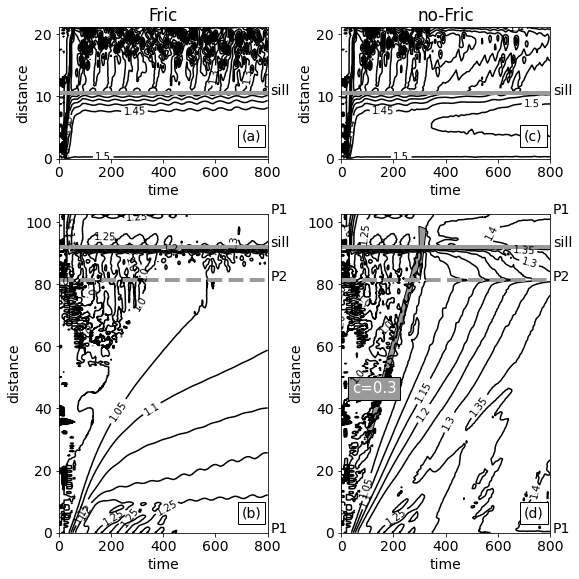

In [18]:
# interpolate to find the backward propagating Kelvin wave speed
p = np.polyfit([200, 300], [60, 90], 1)
t_Kelvin_nofric = np.arange(100, 300 + 1e-6, 1)
d0_Kelvin_nofric = np.polyval(p, t_Kelvin_nofric)
c_Kelvin_nofric = (90-60)/(300-200)

from matplotlib import gridspec
from matplotlib import cm
cmap = cm.RdBu_r
cmap.set_bad('gray', 1.)

fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(3, 2)

ax_a = plt.subplot(gs[0, 0])
ax_b = plt.subplot(gs[-2::, 0])
ax_c = plt.subplot(gs[0, 1])
ax_d = plt.subplot(gs[-2::, 1])

matplotlib.rcParams.update({'font.size': 14})
props = dict(facecolor='w', alpha=1)  # boxstyle='round',

# ---------- Friction model ----------
i = 1
Data1 = xr.open_dataset(model_path + 'Data_' + np.str(i) + '.nc')
Topo1 = xr.open_dataset(model_path + 'Topo_' + np.str(i) + '.nc')
Out1 = xr.open_dataset(model_path + 'Out_' + np.str(i) + '.nc')

# make coordinates correct: v/y means north-south, u/x means west-east and rebuild dataset
x, y, t, d, h, v, u = extract_data(Data1)
v[d < 1e-7] = np.nan
d[d < 1e-7] = np.nan

# data_fric_circ = data_circuit(x, y, t, d, h, v, u, Topo1.xc.data, .6)
# data_fric_circ.to_netcdf('data/Fig7_Fric.nc')
data_fric_circ = xr.open_dataset(
    '../data/Fig7_Fric.nc')

cs_a = (data_fric_circ.h_we+data_fric_circ.d_we).plot.contour(levels=np.arange(
    0, 2+1e-4, 0.05, dtype=float), ax=ax_a, add_colorbar=False, colors='k')
ax_a.clabel(cs_a, np.arange(0, 2+1e-4, 0.05)[26::2], fmt='%1.1f', colors='k', inline_spacing=1, fontsize=10)
ax_a.clabel(cs_a, np.arange(0, 2+1e-4, 0.05)[26+1::2], fmt='%1.2f', colors='k', inline_spacing=1, fontsize=10)
a, idx_yc = find_nearest(data_fric_circ.y_we.data, Topo1.xc.data)
ax_a.plot([0, 800], [data_fric_circ.dis_we[idx_yc],
                     data_fric_circ.dis_we[idx_yc]], color='0.6', lw=4)
ax_a.text(810, data_fric_circ.dis_ea[idx_yc], 'sill', fontsize=14, c='k')
ax_a.set_title('Fric')
ax_a.set_ylabel('distance')
ax_a.text(700, 3, '(a)', fontsize=14, color='k', bbox=props)

cs_b = (data_fric_circ.h_ea+data_fric_circ.d_ea).plot.contour(levels=np.arange(
    0, 2+1e-4, 0.05, dtype=float), ax=ax_b, add_colorbar=False, colors='k')
ax_b.clabel(cs_b, np.arange(0, 2+1e-4, 0.05)[0::2], fmt='%1.1f', colors='k', inline_spacing=1, fontsize=10)
ax_b.clabel(cs_b, np.arange(0, 2+1e-4, 0.05)[1::2], fmt='%1.2f', colors='k', inline_spacing=1, fontsize=10)
a, idx_yc = find_nearest(data_fric_circ.y_ea.data[600::], Topo1.xc.data)
idx_yc += 600
ax_b.plot([0, 800], [data_fric_circ.dis_ea[idx_yc],
                     data_fric_circ.dis_ea[idx_yc]], color='0.6', lw=4)
ax_b.plot([0, 800], [data_fric_circ.dis_ea[data_fric_circ.y_ea.argmax()],
                     data_fric_circ.dis_ea[data_fric_circ.y_ea.argmax()]], linestyle='--', color='0.6', lw=4)
ax_b.text(810, data_fric_circ.dis_ea[0], 'P1', fontsize=14, c='k')
ax_b.text(810, data_fric_circ.dis_ea[idx_yc], 'sill', fontsize=14, c='k')
ax_b.text(810, data_fric_circ.dis_ea[data_fric_circ.y_ea.argmax()], 'P2', fontsize=14, c='k')
ax_b.text(810, data_fric_circ.dis_ea[-1], 'P1', fontsize=14, c='k')

ax_b.set_title('')
ax_b.set_ylabel('distance')
ax_b.text(700, 5, '(b)', fontsize=14, color='k', bbox=props)

# ---------- No-Friction model ----------
i = 11
Data1 = xr.open_dataset(model_path + 'Data_' + np.str(i) + '.nc')
Topo1 = xr.open_dataset(model_path + 'Topo_' + np.str(i) + '.nc')
Out1 = xr.open_dataset(model_path + 'Out_' + np.str(i) + '.nc')

# make coordinates correct: v/y means north-south, u/x means west-east and rebuild dataset
x, y, t, d, h, v, u = extract_data(Data1)
v[d < 1e-7] = np.nan
d[d < 1e-7] = np.nan

# data_nofric_circ = data_circuit(x, y, t, d, h, v, u, Topo1.xc.data, .6)
# data_nofric_circ.to_netcdf(
#     'data/Fig7_NoFric.nc')
data_nofric_circ = xr.open_dataset(
    '../data/Fig7_NoFric.nc')

cs_c = (data_nofric_circ.h_we+data_nofric_circ.d_we).plot.contour(levels=np.arange(
    0, 2+1e-4, 0.05, dtype=float), ax=ax_c, add_colorbar=False, colors='k')
ax_c.clabel(cs_c, np.arange(0, 2+1e-4, 0.05)[26::2], fmt='%1.1f', colors='k', inline_spacing=1, fontsize=10)
ax_c.clabel(cs_c, np.arange(0, 2+1e-4, 0.05)[26+1::2], fmt='%1.2f', colors='k', inline_spacing=1, fontsize=10)
a, idx_yc = find_nearest(data_nofric_circ.y_we.data, Topo1.xc.data)
ax_c.plot([0, 800], [data_nofric_circ.dis_we[idx_yc],
                     data_nofric_circ.dis_we[idx_yc]], color='0.6', lw=4)
ax_c.text(810, data_nofric_circ.dis_ea[idx_yc], 'sill', fontsize=14, c='k')
ax_c.set_title('no-Fric')
ax_c.set_ylabel('distance')
ax_c.text(700, 3, '(c)', fontsize=14, color='k', bbox=props)

cs_d = (data_nofric_circ.h_ea+data_nofric_circ.d_ea).plot.contour(levels=np.arange(
    0, 2+1e-4, 0.05, dtype=float), ax=ax_d, add_colorbar=False, colors='k')
ax_d.clabel(cs_d, np.arange(0, 2+1e-4, 0.05)[0::2], fmt='%1.1f', colors='k', inline_spacing=1, fontsize=10)
ax_d.clabel(cs_d, np.arange(0, 2+1e-4, 0.05)[1::2], fmt='%1.2f', colors='k', inline_spacing=1, fontsize=10)
a, idx_yc = find_nearest(data_nofric_circ.y_ea.data[600::], Topo1.xc.data)
idx_yc += 600
ax_d.plot([0, 800], [data_nofric_circ.dis_ea[idx_yc],
                     data_nofric_circ.dis_ea[idx_yc]], color='0.6', lw=4)
ax_d.plot([0, 800], [data_nofric_circ.dis_ea[data_nofric_circ.y_ea.argmax()],
                     data_nofric_circ.dis_ea[data_nofric_circ.y_ea.argmax()]], linestyle='--', color='0.6', lw=4)
ax_d.arrow(x=t_Kelvin_nofric[0], y=d0_Kelvin_nofric[0], dx=t_Kelvin_nofric[-1] -
           t_Kelvin_nofric[0], dy=d0_Kelvin_nofric[-1]-d0_Kelvin_nofric[0], width=6, facecolor='.6')
ax_d.text(40, 45, 'c='+str(c_Kelvin_nofric), {'fontsize': 15, 'c': 'w', 'bbox': dict(facecolor='0.6')})
ax_d.set_title('')
ax_d.set_ylabel('distance')
ax_d.text(700, 5, '(d)', fontsize=14, color='k', bbox=props)
ax_d.text(810, data_nofric_circ.dis_ea[0], 'P1', fontsize=14, c='k')
ax_d.text(810, data_nofric_circ.dis_ea[idx_yc], 'sill', fontsize=14, c='k')
ax_d.text(810, data_nofric_circ.dis_ea[data_nofric_circ.y_ea.argmax()], 'P2', fontsize=14, c='k')
ax_d.text(810, data_nofric_circ.dis_ea[-1], 'P1', fontsize=14, c='k')

plt.tight_layout(pad=0.4, w_pad=0, h_pad=.4)
plt.savefig('../pics/Fig7.eps')